# Viscous streaming solution in frequency domain

In this notebook, we seek to solve for viscous streaming in the frequency domain.

$$ \mathcal{L}_\alpha u = i\alpha u  - L u = f $$

where $\alpha$ is a real-valued constant, $L$ is the grid Laplacian operator, and $u$ is a complex-valued field on the grid. It should be noted that $\alpha = \omega \Delta x^2/\nu$, where $\omega$ is a frequency, $\nu$ is kinematic viscosity, and $\Delta x$ is the grid spacing. The operator $\mathcal{L}_\alpha$ we will call the Helmholtz operator.

In [5]:
using Pkg
pkg"update ViscousFlow"

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
  Updating git-repo `https://github.com/jdeldre/ViscousFlow.jl.git`
Fetching: [========================================>]  100.0 %.0 % Resolving package versions...
  Updating `~/JuliaProjects/ViscousStreaming/notebooks/Project.toml`
  [103da179] ~ ViscousFlow v0.1.8 #master (https://github.com/jdeldre/ViscousFlow.jl.git)
  Updating `~/JuliaProjects/ViscousStreaming/notebooks/Manifest.toml`
  [103da179] ~ ViscousFlow v0.1.8 #master (https://github.com/jdeldre/ViscousFlow.jl.git)


In [6]:
using ViscousFlow

┌ Info: Precompiling ViscousFlow [103da179-b3e4-57c1-99a4-586354eb2c5a]
└ @ Base loading.jl:1242
[ Info: Building and caching LGF table


In [7]:
using Plots

In [1]:
using Pkg
pkg"st"

    Status `~/JuliaProjects/ViscousStreaming/notebooks/Project.toml`
  [459566f4] DiffEqCallbacks v2.8.0
  [a98d9a8b] Interpolations v0.12.2
  [4138dd39] JLD v0.9.1
  [7a12625a] LinearMaps v2.4.0
  [51fcb6bd] NamedColors v0.2.0
  [1dea7af3] OrdinaryDiffEq v5.14.0
  [92933f4c] ProgressMeter v1.1.0
  [1fd47b50] QuadGK v2.1.0
  [295af30f] Revise v2.2.1
  [103da179] ViscousFlow v0.1.8 #master (https://github.com/jdeldre/ViscousFlow.jl.git)
  [47fb7046] ViscousStreaming v0.1.0 #master (https://github.com/jdeldre/ViscousStreaming.jl.git)


In [9]:
using ViscousStreaming

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/ViscousStreaming/UPKy8.ji for ViscousStreaming [47fb7046-13b0-40db-b6a6-74fa44cf0959]
└ @ Base loading.jl:1240


In [8]:
Re = 40
ϵ = 0.1

1.0

### Set up analytical solution

In [10]:
p = StreamingParams(ϵ,Re)

Streaming flow parameters with Re = 40.0, ϵ = 0.1


In [11]:
s = AnalyticalStreaming(p)

Maximum residual on W₁ = 1.1368683772161603e-13
BC residual on Ψ₁(1) = 2.7755575615628914e-17
BC residual on dΨ₁(1) = 5.23691153334427e-16
Maximum residual on Ws₂ = 1.3073986337985843e-12
BC residual on Ψs₂(1) = 0.0
BC residual on dΨs₂(1) = 8.881784197001252e-16
Maximum residual on W₂ = 2.1179418493558537e-12
BC residual on Ψ₂(1) = 1.734723475976807e-17
BC residual on dΨ₂(1) = 0.0


Analytical streaming flow solution for
single cylinder with Re = 40.0, ϵ = 0.1


### Create a system structure and setup routines
These should go into ViscousStreaming.jl

In [12]:
abstract type StreamingSystem{NX,NY,N} end

In [13]:
struct FrequencyStreaming{NX,NY,N} <: StreamingSystem{NX,NY,N}
    "Reynolds number (ΩL^2/ν)"
    Re::Float64
    
    "Amplitude parameter"
    ϵ::Float64
    
    "Grid metadata"
    grid::Fields.PhysicalGrid{2}
    
    # Operators
    "Laplacian operator"
    L::Fields.Laplacian{NX,NY}
    
    "Helmholtz operator"
    LH::Fields.Helmholtz{NX,NY}
    
    "Body coordinate data"
    X::VectorData{N,Float64}
    
    "Regularization and interpolation"
    reg::Regularize{N}
    Hmat::RegularizationMatrix
    Emat::InterpolationMatrix
    
    "Masks"
    inside::MaskType
    outside::MaskType
    dlayer::DoubleLayer
    
    "Saddle point systems"
    S₁::SaddleSystem
    S₂::SaddleSystem
    
end

In [14]:
function FrequencyStreaming(Re, ϵ, Δx, xlimits::Tuple{Real,Real},ylimits::Tuple{Real,Real},b::Union{Body,BodyList};
                       ddftype=Fields.Goza)

    X = VectorData(collect(b))
    
    
    # set up grid
    g = PhysicalGrid(xlimits,ylimits,Δx)
    NX, NY = size(g)
    N = length(X) ÷ 2
    
    # Basic data
    w = Nodes(Dual,(NX,NY),dtype=ComplexF64)
    f = VectorData(X,dtype=ComplexF64)

    L = plan_laplacian(NX,NY,with_inverse=true,dtype=ComplexF64)
    
    α = Re*Δx^2
    LH = plan_helmholtz(NX,NY,α,with_inverse=true)
    
    # Regularization and interpolation
    regop = Regularize(X,Δx,I0=origin(g),issymmetric=true,ddftype=ddftype)
    H, E = RegularizationMatrix(regop,VectorData(X,dtype=ComplexF64),Edges(Primal,(NX,NY),dtype=ComplexF64))
    
    # construct masks and double layer operator
    dlayer = DoubleLayer(b,regop,w)
    inside = Mask(dlayer)
    outside = ComplementaryMask(inside)
    
    
    # Set up operators
    #=
    First-order system
    =#
    B1₁ᵀ(f::VectorData{N,T}) where {N,T} = Curl()*(H*f)
    B1₂(w::Nodes{Dual,NX,NY,T}) where {NX,NY,T} = -(E*(Curl()*(L\w)))
    A1⁻¹(w::Nodes{Dual,NX,NY,T}) where {NX,NY,T} = LH\w

    #=
    Second-order mean system
    =#
    B2₂(w::Nodes{Dual,NX,NY,T}) where {NX,NY,T} = -(E*(Curl()*(L\outside(w))))
    A2⁻¹(w::Nodes{Dual,NX,NY,T}) where {NX,NY,T} = -(L\outside(w))
    
    # Set up saddle point systems
    
    S₁ = SaddleSystem((w,f),(A1⁻¹,B1₁ᵀ,B1₂),issymmetric=true,store=true)
    S₂ = SaddleSystem((w,f),(A2⁻¹,B1₁ᵀ,B2₂),issymmetric=true,store=true)
    
    return FrequencyStreaming{NX,NY,N}(Re,ϵ,g,L,LH,X,regop,H,E,inside,outside,dlayer,S₁,S₂)
end

FrequencyStreaming

In [15]:
#=
These functions should be defined generally in ViscousFlow for all systems.
=#

import Base: size

# some convenience functions
"""
    size(sys::NavierStokes,d::Int) -> Int

Return the number of indices of the grid used by `sys` along dimension `d`.
"""
size(sys::StreamingSystem{NX,NY},d::Int) where {NX,NY} = d == 1 ? NX : NY

"""
    size(sys::NavierStokes) -> Tuple{Int,Int}

Return a tuple of the number of indices of the grid used by `sys`
"""
size(sys::StreamingSystem{NX,NY}) where {NX,NY} = (size(sys,1),size(sys,2))

"""
    cellsize(sys::NavierStokes) -> Float64

Return the grid cell size of system `sys`
"""
Fields.cellsize(sys::StreamingSystem) = cellsize(sys.grid)

"""
    origin(sys::NavierStokes) -> Tuple{Int,Int}

Return a tuple of the indices of the primal node that corresponds to the
physical origin of the coordinate system used by `sys`. Note that these
indices need not lie inside the range of indices occupied by the grid.
For example, if the range of physical coordinates occupied by the grid
is (1.0,3.0) x (2.0,4.0), then the origin is not inside the grid.
"""
Fields.origin(sys::StreamingSystem) = origin(sys.grid)

ViscousFlow.Fields.origin

In [33]:
function Ūr₂(w::Nodes{Dual,NX,NY,ComplexF64},sys::FrequencyStreaming{NX,NY}) where {NX,NY}

  Ww = Edges(Dual,w)
  Qq = Edges(Dual,w)  
  Δx = cellsize(sys)

  Fields.interpolate!(Qq,curl(sys.L\conj(w))) # -velocity, on dual edges

  return 0.5*Δx*divergence(Qq∘Fields.interpolate!(Ww,w)) # -0.5*∇⋅(wu)

end

Ūr₂ (generic function with 1 method)

In [34]:
sys.grid

PhysicalGrid{2}((600, 600), (300, 300), 0.02, ((-5.98, 5.98), (-5.98, 5.98)))

In [36]:
abstract type StreamingComputational end

struct FirstOrderComputational{NX,NY} <: StreamingComputational
    Re :: Float64
    ϵ :: Float64
    Ω :: Float64
    g :: PhysicalGrid{2}
    W :: Nodes{Dual,NX,NY,ComplexF64}
    Ψ :: Nodes{Dual,NX,NY,ComplexF64}
    U :: Edges{Primal,NX,NY,ComplexF64}
end

struct SecondOrderMeanComputational{NX,NY} <: StreamingComputational
    Re :: Float64
    ϵ :: Float64
    Ω :: Float64
    g :: PhysicalGrid{2}
    W :: Nodes{Dual,NX,NY,ComplexF64}
    Ψ :: Nodes{Dual,NX,NY,ComplexF64}
    U :: Edges{Primal,NX,NY,ComplexF64}
end

In [37]:
function (sys::FrequencyStreaming{NX,NY,N})(U::Vector{Vector{T}},bl::BodyList) where {NX,NY,N,T<:Number}
    
    Ω = 1.0
        
    w1 = Nodes(Dual,size(sys),dtype=ComplexF64)
    w2 = Nodes(Dual,size(sys),dtype=ComplexF64)
    f1 = VectorData(sys.X,dtype=ComplexF64)
    f2 = VectorData(sys.X,dtype=ComplexF64)
    
    # first-order solution
    Ur₁ = zero(w1)
    Fr₁ = deepcopy(f1)
    for i in 1:length(bl)
        ui = view(Fr₁.u,bl,i)
        vi = view(Fr₁.v,bl,i)
        fill!(ui,U[i][1])
        fill!(vi,U[i][2])
    end
    rhs₁ = deepcopy((Ur₁,Fr₁))
    
    w1, f1 = sys.S₁\rhs₁
    
    ω₁ = vorticity(w1,sys)
    ψ₁ = streamfunction(w1,sys)
    u₁ = velocity(w1,sys)
    soln1 = FirstOrderComputational(sys.Re,sys.ϵ,Ω,sys.grid,ω₁,ψ₁,u₁)
    
    # construct drift flow
    udual = Nodes(Dual,w1)
    vdual = Nodes(Dual,w1)
    Fields.interpolate!(udual,u₁.u)
    Fields.interpolate!(vdual,u₁.v)
    sd = 0.5im/Ω*udual∘conj(vdual)/cellsize(sys)

    ψd = cellsize(sys)*sd
    ud = curl(sd)
    ωd = curl(ud)/cellsize(sys)
    udb = sys.Emat*ud
    
    sdsoln = SecondOrderMeanComputational(sys.Re,sys.ϵ,Ω,sys.grid,ωd,ψd,ud)
    
    # second-order mean solution
    rhs₂ = deepcopy((Re*Ūr₂(w1,sys),-udb))
    w2, f2 = sys.S₂\rhs₂
    
    ω₂ = vorticity(sys.outside(w2),sys)
    ψ₂ = streamfunction(sys.outside(w2),sys)
    u₂ = velocity(sys.outside(w2),sys)
    
    soln2 = SecondOrderMeanComputational(sys.Re,sys.ϵ,Ω,sys.grid,ω₂,ψ₂,u₂)
     
    return soln1, soln2, sdsoln
    
end

In [23]:
(sys::FrequencyStreaming{NX,NY,N})(U::Vector{T},body::Body) where {NX,NY,N,T<:Number} = sys([U],BodyList([body]))

### Set up the basic system

#### Set up the grid cell size and approximate dimensions

In [18]:
Δx = 0.02
xlim = (-5.98,5.98)
ylim = (-5.98,5.98)

(-5.98, 5.98)

#### Set up a body

In [19]:
bl = BodyList()
tl = RigidTransform[]

0-element Array{RigidTransform,1}

In [20]:
n = 150
body = Circle(1.0,n)
bL = deepcopy(body)
bR = deepcopy(body)

Circular body with 150 points and radius 1.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


In [15]:
# left cylinder
cent = (-3.0,0.0)
α = 0.0
TL = RigidTransform(cent,α)
TL(bL) # transform the body to the current configuration

# right cylinder
cent = (3.0,0.0)
α = 0.0
TR = RigidTransform(cent,α)
TR(bR) # transform the body to the current configuration

push!(tl,TL)
push!(tl,TR)

push!(bl,bL)
push!(bl,bR)

2-element Array{Body,1}:
 Circular body with 150 points and radius 1.0
   Current position: (-3.0,0.0)
   Current angle (rad): 0.0

 Circular body with 150 points and radius 1.0
   Current position: (3.0,0.0)
   Current angle (rad): 0.0
 

#### Set up the system

In [21]:
@time sys = FrequencyStreaming(Re,ϵ,Δx,xlim,ylim,body);

110.698011 seconds (414.22 M allocations: 44.949 GiB, 11.94% gc time)


In [22]:
size(sys)

(600, 600)

In [38]:
soln1, soln2, sdsoln = sys([1.0,0.0],body);

In [42]:
ω₁, ψ₁, u₁, ω₂, ψ₂, u₂, ψ̄₂, ū₂ = sys([[1.0,0.0],[0.0,0.0]],bl);

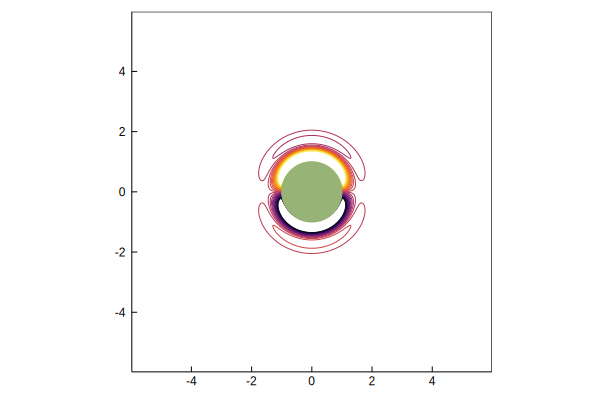

In [39]:
xg, yg = coordinates(soln1.W,sys.grid)
plot(xg,yg,real(soln1.W),levels=range(-2,2,length=30),clim=(-2,2),xlim=xlim,ylim=ylim)
plot!(body)

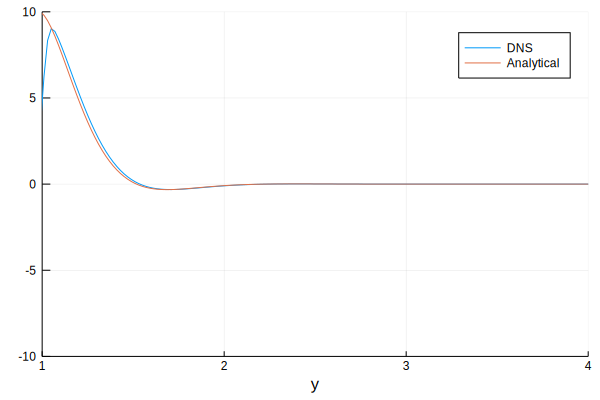

In [40]:
ix = 301
plot(yg,real(soln1.W)[301,:],ylim=(-10,10),xlim=(1,4),label="DNS",xlabel="y")
plot!(yg,map(y -> vorticity(xg[ix],y,0.0,firstorder(s)),abs.(yg)),label="Analytical")

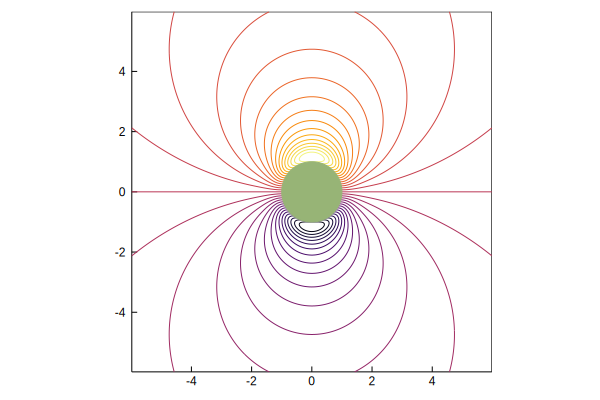

In [42]:
plot(xg,yg,real(soln1.Ψ),levels=range(-1,1,length=31),xlim=xlim,ylim=ylim)
plot!(body)

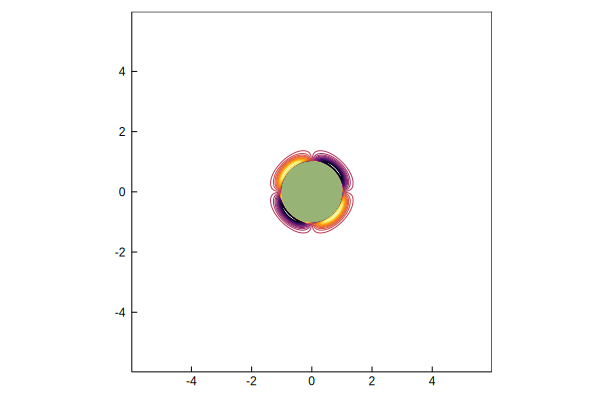

In [43]:
plot(xg,yg,real(soln2.W),levels=range(-10,10,length=30),clim=(-10,10),xlim=xlim,ylim=ylim)
plot!(body)

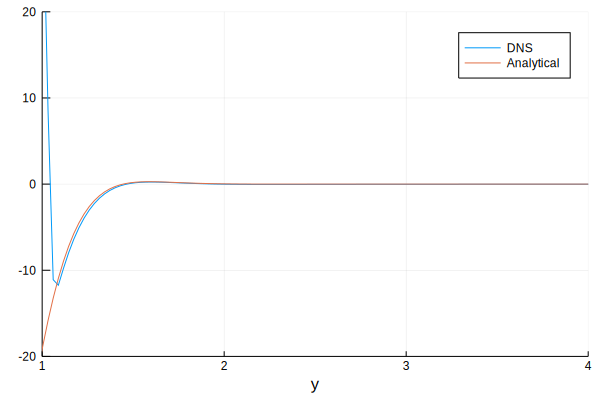

In [44]:
rg = sqrt.(xg.^2+yg.^2)
plot(rg,map(ix -> real(soln2.W)[ix,ix],1:length(rg)),ylim=(-20,20),xlim=(1,4),label="DNS",xlabel="y")
plot!(rg,map(x -> vorticity(x,x,secondordermean(s)),xg),label="Analytical")

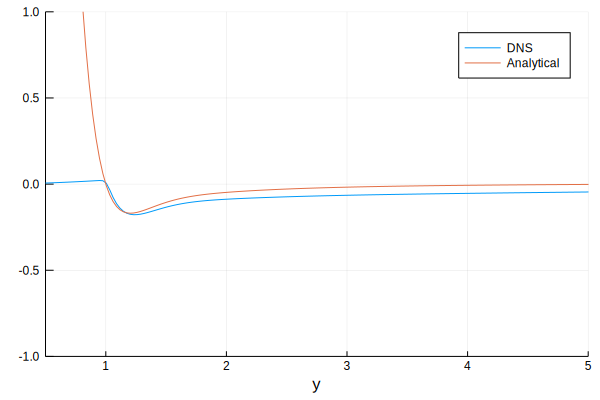

In [45]:
ig = 120
rg = sqrt.(xg[ig:end].^2+yg[ig:end].^2)
plot(rg,map(ix -> real(soln2.Ψ)[ix,ix],ig:length(xg)),ylim=(-1,1),xlim=(0.5,5),label="DNS",xlabel="y")
#plot!(rg,map(ix -> Δx*real(s22)[ix,ix],ig:length(xg)),ylim=(-1,1),xlim=(0.5,2),label="DNS",xlabel="y")
plot!(rg,map(x -> streamfunction(x,x,secondordermean(s)),xg[ig:end]),label="Analytical")

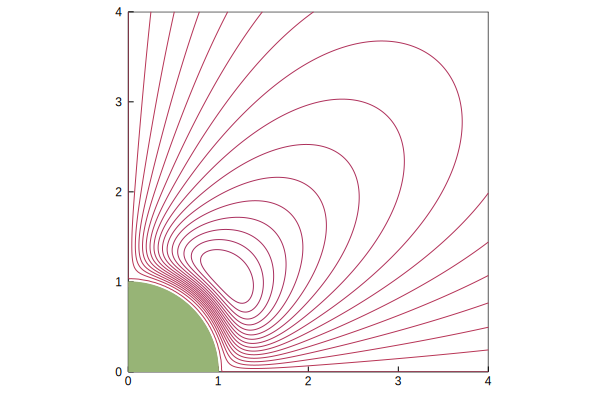

In [46]:
plot(xg,yg,real(soln2.Ψ + sdsoln.Ψ),levels=range(-0.1,0.1,length=31),clim=(-1,1),xlim=(0,4),ylim=(0,4))
plot!(body)

### Set up the first order problem

In [25]:
w1 = Nodes(Dual,size(sys),dtype=ComplexF64)
w2 = Nodes(Dual,size(sys),dtype=ComplexF64)
f1 = VectorData(sys.X,dtype=ComplexF64)
f2 = VectorData(sys.X,dtype=ComplexF64)
nx, ny = size(sys)

(600, 600)

Create specific routines for saddle-point problem, with this system

In [668]:
B1₁ᵀ(f) = streaming_B1₁ᵀ(f,sys)
B1₂(w) = streaming_B1₂(w,sys)
A1⁻¹(w) = streaming_A1⁻¹(w,sys)

A1⁻¹ (generic function with 1 method)

In [669]:
@time S₁ = SaddleSystem((w1,f1),(A1⁻¹,B1₁ᵀ,B1₂),issymmetric=true,store=true)

 31.661396 seconds (216.53 k allocations: 11.332 GiB, 8.37% gc time)


Saddle system with 300 constraints and
   State of type Nodes{Dual,600,600,Complex{Float64}}
   Force of type VectorData{150,Complex{Float64}}


In [657]:
B2v₁ᵀ(f) = streaming_B1₁ᵀ(f,sys)
B2v₂(w) = streaming_B2₂(w,sys)
A2v⁻¹(w) = streaming_A2⁻¹(w,sys)

A2v⁻¹ (generic function with 1 method)

In [659]:
S̄₂ = SaddleSystem((w2,f2),(A2v⁻¹,B2v₁ᵀ,B2v₂),issymmetric=true,store=true)

Saddle system with 300 constraints and
   State of type Nodes{Dual,600,600,Complex{Float64}}
   Force of type VectorData{150,Complex{Float64}}


#### Set the right-hand side of first-order problem

In [27]:
Ux = 1.0
Uy = 0.0
Ur₁ = zero(w1)
Fr₁ = deepcopy(f1)
fill!(Fr₁.u,Ux)
fill!(Fr₁.v,Uy)
rhs₁ = deepcopy((Ur₁,Fr₁));

In [28]:
w1, f1 = sys.S₁\rhs₁;

In [29]:
#=ω₁ = vorticity(w1,sys)
ψ₁ = streamfunction(w1,sys)
u₁ = velocity(w1,sys);
=#

### Construct drift velocity

In [43]:
#ψd = Nodes(Dual,w1)
#ψdb = ScalarData(n,dtype=ComplexF64)
#Hn, En = RegularizationMatrix(sys.reg,ψdb,ψd)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [33]:
udual = Nodes(Dual,w1)
vdual = Nodes(Dual,w1)
Fields.interpolate!(udual,u₁.u)
Fields.interpolate!(vdual,u₁.v)
sd = 0.5im/Ω*udual∘conj(vdual)/cellsize(sys)
qd = curl(sd)
#ds = ScalarData(Bodies.dlength(body))/cellsize(sys)
#normals = VectorData(Bodies.normal(body))
#qtang = cross(normals,sys.Emat*qd);

ψd = cellsize(sys)*sd
qdb = sys.Emat*qd
#wd = -(sys.L*sd)
#sin2θ = ScalarData(n,dtype=ComplexF64)
#sin2θ .= 2*sys.X.u.*sys.X.v

#wd = curl(qd)
#wdb = En*wd; #En*(wd∘mask);
#wdb2 = En2*wd; #*(wd∘mask2);

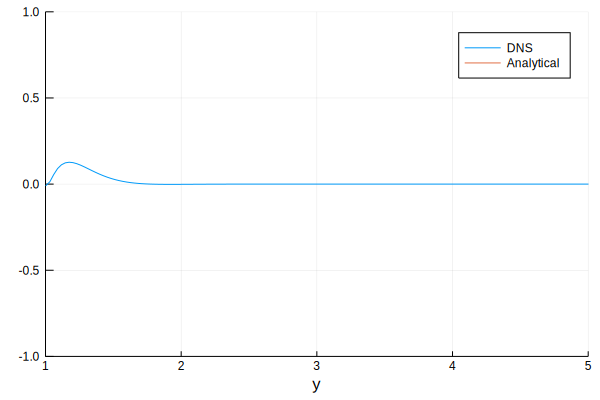

In [587]:
ig = 120
rg = sqrt.(xg[ig:end].^2+yg[ig:end].^2)
plot(rg,map(ix -> real(ψd)[ix,ix],ig:length(xg)),ylim=(-1,1),xlim=(1,5),label="DNS",xlabel="y")
#plot!(rg,map(ix -> Δx*real(s22)[ix,ix],ig:length(xg)),ylim=(-1,1),xlim=(0.5,2),label="DNS",xlabel="y")
plot!(rg,map(x -> real(Ψsd(x)),rg),label="Analytical")

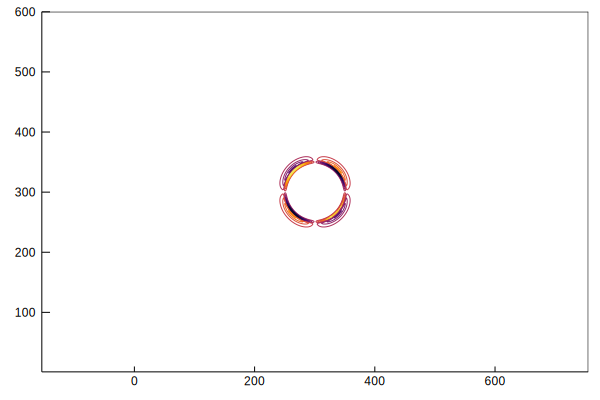

In [588]:
plot(real(wd))

### Second-order mean solution

Solved with scalar constraints on vorticity and streamfunction

In [49]:
f2 = ScalarData(n,dtype=ComplexF64)
B2₁ᵀ(f::ScalarData{N,T}) where {N,T} = Hn*f
B2₂(w::Nodes{Dual,NX,NY,T}) where {NX,NY,T} = En*w
Ā2⁻¹(w::Nodes{Dual,NX,NY,T}) where {NX,NY,T} = -(sys.L\w)

Ā2⁻¹ (generic function with 1 method)

In [50]:
S₂ = SaddleSystem((w2,f2),(Ā2⁻¹,B2₁ᵀ,B2₂),issymmetric=true,store=true)

Saddle system with 150 constraints and
   State of type Nodes{Dual,600,600,Complex{Float64}}
   Force of type ScalarData{150,Complex{Float64}}


Solved with constrained velocity

In [1081]:
#=
function Fr₂(w::Nodes{Dual,NX,NY,ComplexF64},g::PhysicalGrid) where {NX,NY}
  fact = 1 #2.4 #2.25 #2 # not sure how to explain this factor yet.
  
  Δx⁻¹ = 1/cellsize(g)
    
  Fq = Edges(Primal,w,dtype=ComplexF64)  
  Vb = VectorData(X,dtype=ComplexF64)  
  Ax = -im*Ux/Ω
  Ay = -im*Uy/Ω
    
  Fq .= curl(L\conj(w)) # -v₁*
  Vb .= dEx*Fq # dv₁*/dx*Δx
  Vb.u .*= -fact*Δx⁻¹*Ax
  Vb.v .*= -fact*Δx⁻¹*Ax
  Vbtmp = deepcopy(Vb) # -X⋅dv₁*/dx
  Vb .= dEy*Fq # dv₁/dy*Δx
  Vb.u .*= -fact*Δx⁻¹*Ay
  Vb.v .*= -fact*Δx⁻¹*Ay
  Vbtmp .+= Vb # -X⋅dv₁*/dx - Y.⋅dv₁*/dy
  return 0.5*Vbtmp

end
=#

Fr₂ (generic function with 1 method)

In [1200]:
#=
wN = VectorData(n,dtype=ComplexF64)
qN = Edges(Dual,w1)
Hde, Ede = RegularizationMatrix(regop2,wN,qN)
=#

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

#### Solve for vorticity

In [492]:
#wdb = -Wsd(1)*sin2θ*cellsize(sys)
wrhs = Re*Ur₂(w1,sys) #- dlayer(wdb) #+ 2π/(n*Δx)*divergence(Hde*VectorData(-N.u.*wdb2,-N.v.*wdb2))
rhsw₂ = deepcopy((wrhs,2*0.5*wdb))
w2, f2 = S₂\rhsw₂;

In [493]:
ω₂ = vorticity(outside(w2),sys);

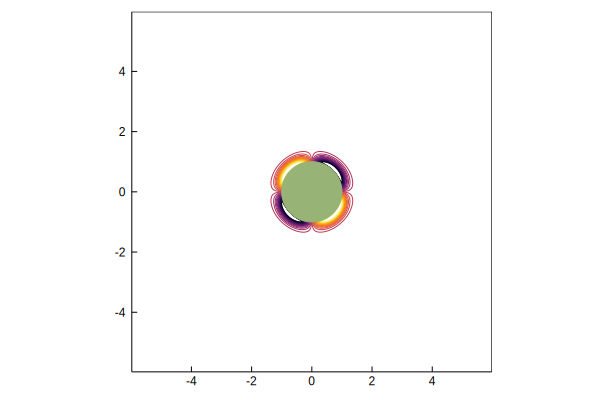

In [494]:
plot(xg,yg,real(ω₂),levels=range(-10,10,length=30),clim=(-10,10),xlim=xlim,ylim=ylim)
plot!(body)

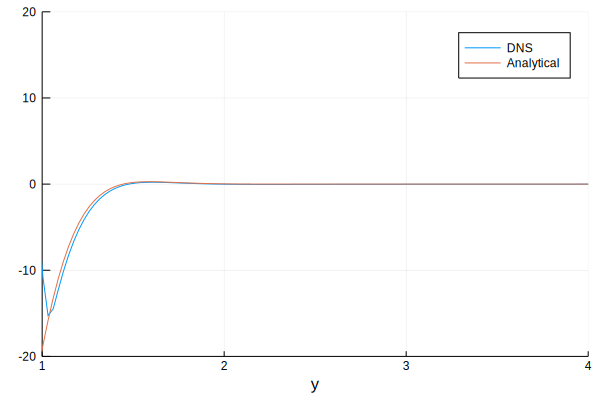

In [495]:
rg = sqrt.(xg.^2+yg.^2)
plot(rg,map(ix -> real(ω₂)[ix,ix],1:length(rg)),ylim=(-20,20),xlim=(1,4),label="DNS",xlabel="y")
plot!(rg,map(x -> vorticity(x,x,secondordermean(s)),xg),label="Analytical")

#### Solve for streamfunction

In [589]:
wrhs = outside(w2)
rhss₂ = deepcopy((wrhs,zero(f2)))
s2, g2 = S₂\rhss₂;

MethodError: MethodError: no method matching adjoint(::Tuple{Nodes{Dual,600,600,Complex{Float64}},VectorData{150,Complex{Float64}}})
Closest candidates are:
  adjoint(!Matched::Missing) at missing.jl:79
  adjoint(!Matched::LightGraphs.DefaultDistance) at /Users/jeff/.julia/packages/LightGraphs/HsNig/src/distance.jl:22
  adjoint(!Matched::Number) at number.jl:193
  ...

In [476]:
ψ₂ = outside(s2)*cellsize(sys)
ψ̄₂ = ψ₂ + ψd;

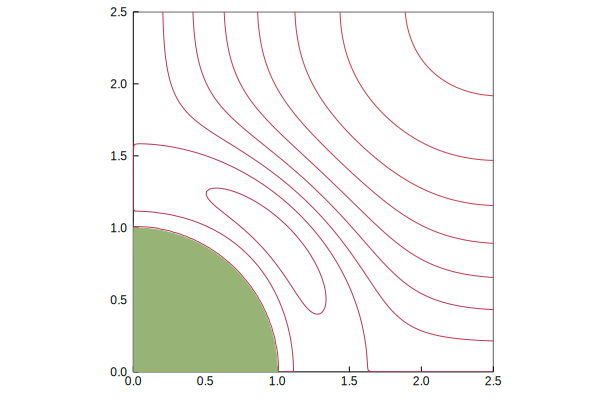

In [513]:
plot(xg,yg,real(ψ̄₂),levels=range(-0.2,0.2,length=31),clim=(-1,1),xlim=(0,2.5),ylim=(0,2.5))
#plot!(xg,yg,real(s22),levels=range(-10,10,length=31),clim=(-10,10),xlim=(0,4),ylim=(0,4))

plot!(body)

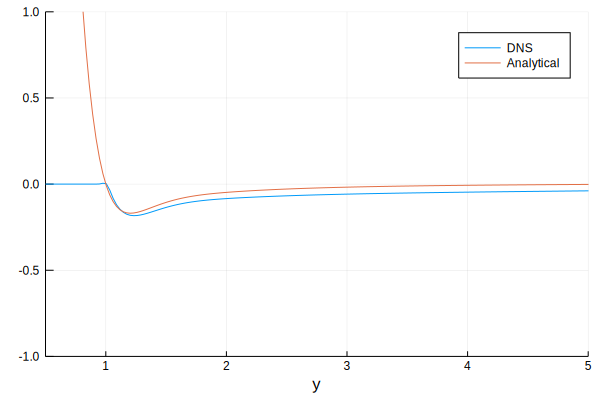

In [478]:
ig = 120
rg = sqrt.(xg[ig:end].^2+yg[ig:end].^2)
plot(rg,map(ix -> real(ψ₂)[ix,ix],ig:length(xg)),ylim=(-1,1),xlim=(0.5,5),label="DNS",xlabel="y")
#plot!(rg,map(ix -> Δx*real(s22)[ix,ix],ig:length(xg)),ylim=(-1,1),xlim=(0.5,2),label="DNS",xlabel="y")
plot!(rg,map(x -> streamfunction(x,x,secondordermean(s)),xg[ig:end]),label="Analytical")

### Second order solution with constrained velocity

In [36]:
rhs₂ = deepcopy((Re*Ur₂(w1,sys),-qdb))
w2, f2 = sys.S₂\rhs₂;

In [548]:
#=
ψ₂ = outside(s2)*cellsize(sys)
ψ̄₂ = ψ₂ + ψd;
=#

In [38]:
ω₂ = vorticity(sys.outside(w2),sys);
ψ₂ = streamfunction(sys.outside(w2),sys);
ψ̄₂ = ψ₂ + ψd;

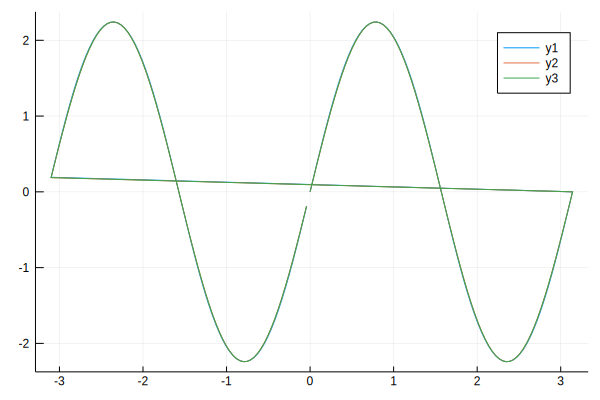

In [553]:
plot(θ,(-real(q2b.u).*sin.(θ)+real(q2b.v).*cos.(θ)))
plot!(θ,real(0.25im*(dUr₁dr(1)+dUθ₁dr(1)))*sin.(2θ))
plot!(θ,real(s.s2s.Uθ₂(1))*sin.(2θ))

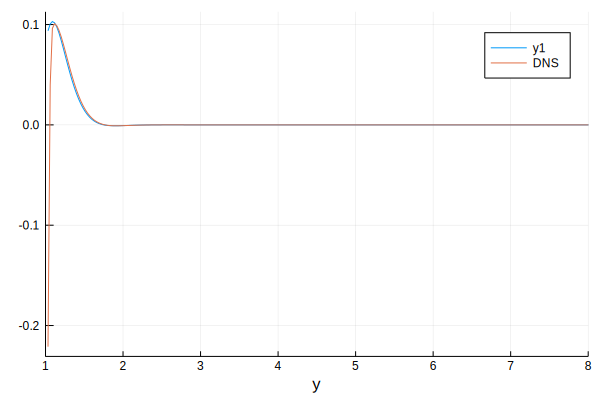

In [496]:
ig = 337
f0dns = Re*Ur₂(w1,g)/cellsize(g)
rg = sqrt.(xg[ig:end].^2+yg[ig:end].^2)
#plot(rg,map(ix -> real(ψ̄₂)[ix,ix],ig:length(xg)),ylim=(-1,1),xlim=(1,8),label="DNS",xlabel="y")
plot(rg,map(r -> cellsize(g)^2*real(f₀(r)),rg),xlim=(1,8))
plot!(rg,map(ix -> real(f0dns[ix,ix]),ig:length(xg)),label="DNS",xlabel="y")

In [487]:
ig = 337
xg[ig]^2+yg[ig]^2

1.0657999999999999

In [457]:
using SpecialFunctions

In [452]:
macro create_dual2(f,nu,c,d,hankel)
    SF = :SpecialFunctions
    H = :($hankel)
    _f = Symbol("_",f)
    defs = quote
                $(_f)(x)  = $SF.$H($nu,$c*x)/$d
                $f = ViscousStreaming.ComplexFunc($(_f))
           end
    return esc(defs)
end

@create_dual2 (macro with 1 method)

In [515]:
s.s1.Uθ₁(1)

-0.9999999999999996 - 2.7755575615628914e-16im

In [810]:
frhs = ScalarData(n,dtype=ComplexF64)
fill!(frhs,1.0)
rhs = (zero(w1),frhs)
u, f = S₂\rhs

(Dual nodes in a (nx = 600, ny = 600) cell grid of type Complex{Float64} data
  Number of Dual nodes: (nx = 600, ny = 600), Complex{Float64}[0.010660903428464449 - 8.535669406042238e-16im, 0.0106609851811876 + 3.164724799944896e-16im, 0.010661228277682464 + 3.0655483098134636e-16im, 0.010661625017577876 - 7.154766502235327e-16im, 0.010662163865311044 + 6.353319011113937e-16im, 0.010662829755193913 - 3.266260788239991e-16im, 0.010663600349570637 - 7.962260439321423e-17im, 0.010664457307836652 + 7.223533344178607e-16im, 0.010665371572651385 - 1.0107226155325483e-15im, 0.010666320467550361 + 5.661480425746298e-16im  …  0.010667274887523705 - 4.517640357005887e-17im, 0.010666320467521659 - 5.221905978053257e-16im, 0.01066537157267716 + 8.940224852150372e-16im, 0.010664457307813756 - 8.383355310176723e-16im, 0.010663600349584253 + 3.670136132035432e-16im, 0.01066282975517641 + 4.40141234278404e-16im, 0.010662163865341611 - 1.0921044322291455e-15im, 0.010661625017550622 + 1.2671419725431335e

In [934]:
fb = 1.0
frhs = ScalarData(n,dtype=ComplexF64)
fill!(frhs,fb)
wrhs = 2π/(n*Δx)*divergence(Hr*N*fb)
rhs = (wrhs,0.5*frhs)
u, f = S₂\rhs;

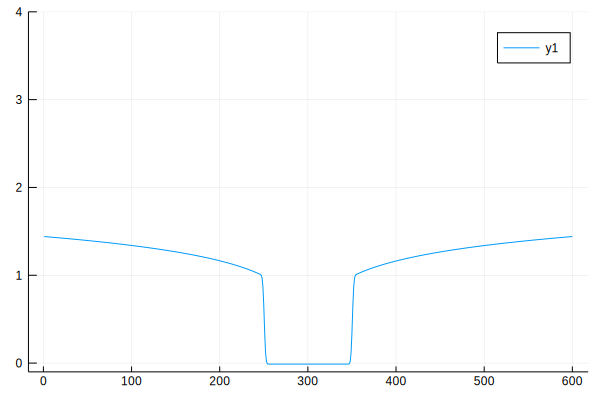

In [935]:
plot(real(u)[:,301],ylim=(-0.1,4))

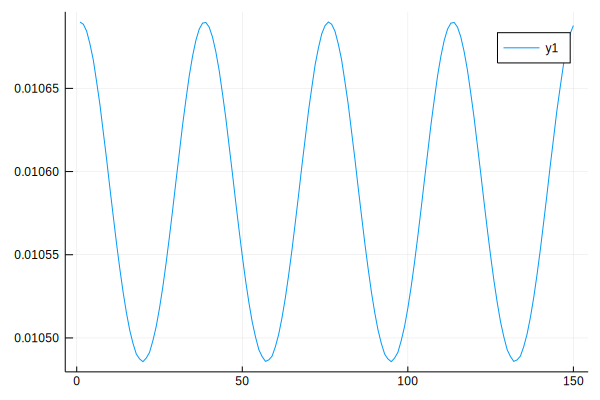

In [931]:
plot(real(f))

In [250]:
using SpecialFunctions

In [254]:
macro create_dual(f,nu,c,d,hankel)
    SF = :SpecialFunctions
    H = :($hankel)
    _f = Symbol("_",f)
    defs = quote
                $(_f)(x)  = $SF.$H($nu,$c*x)/$d
                $f = ViscousStreaming.ComplexFunc($(_f))
           end
    return esc(defs)
end

@create_dual (macro with 1 method)

In [255]:
@create_dual(X,0,p.γ,p.H₀,hankelh1)
@create_dual(Y,1,p.γ,p.H₀,hankelh1)
@create_dual(Z,2,p.γ,p.H₀,hankelh1)

Complex function


In [260]:
n1inf=100000
n120=400000
K = 2
  fakefact = 1
  #f₀ = ComplexFunc(r -> -0.5*p.γ²*p.Re*(0.5*(p.C*conj(X(r))-conj(p.C)*X(r))/r^2 + X(r)*conj(Z(r)) - conj(X(r))*Z(r)))
  f₀ = ViscousStreaming.ComplexFunc(r -> -p.γ²*p.Re*(0.5*p.C*conj(X(r))/r^2 + X(r)*conj(Z(r))))

  f̃₀ = ViscousStreaming.ComplexFunc(r -> f₀(r) - 0.5*p.γ²*p.Re*(-0.5*conj(Z(r))+0.5*Z(r)))
  I⁻¹ = ViscousStreaming.ComplexIntegral(r->f₀(r)/r,1,Inf,length=n1inf)
  I¹ = ViscousStreaming.ComplexIntegral(r->f₀(r)*r,1,Inf,length=n1inf)
  I³ = ViscousStreaming.ComplexIntegral(r->f₀(r)*r^3,1,20,length=n120)
  I⁵ = ViscousStreaming.ComplexIntegral(r->f₀(r)*r^5,1,20,length=n120)
  Ψs₂ = ViscousStreaming.ComplexFunc(r -> -r^4/48*I⁻¹(r) + r^2/16*I¹(r) + I³(r)/16 + I⁻¹(1)/16 - I¹(1)/8 - fakefact*0.25im*p.γ*Y(1) +
  1/r^2*(-I⁵(r)/48-I⁻¹(1)/24+I¹(1)/16 + fakefact*0.25im*p.γ*Y(1)))
  Ws₂ = ViscousStreaming.D²(Ψs₂,K)
  Usr₂, Usθ₂ = ViscousStreaming.curl(Ψs₂,K)
nothing

In [261]:
Ψsd = ViscousStreaming.ComplexFunc(r -> -0.5im*(p.C/r^2-Z(r))*conj(X(r)))

Complex function


In [275]:
Wsd = ViscousStreaming.D²(Ψsd,K)

Complex function
